In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


date : Thu Sep  5 22:41:48 PDT 2019
hostname : bragi
whoami : tmb
pwd : /home/tmb/exp/icdar2019-text

[(5, 128, 368, 1), (5, 128, 528, 1), (5, 112, 368, 1), (5, 112, 576, 1), (5, 128, 464, 1)]
1.0
cuda:0


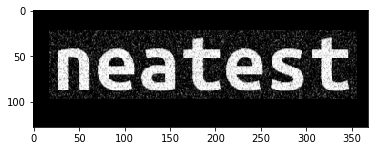

In [3]:
exec(open("startup.py").read())
images, targets, ilens, tlens = next(iter(training_dl))
imshow(images[0,:,:,0].detach().numpy())
print([tuple(sample[0].shape) for sample in islice(training_dl, 0, 5)])
print(images.max().item())
print(device)

In [4]:
!awk '/ocr_resnet/' RS="\n\n" models.py


def make_ocr_resnet(noutput=noutput):
    model = nn.Sequential(
        layers.Input("BHWD", reorder="BDHW", range=(0, 1), sizes=[None, 1, None, None]),
        *conv2mp(64, 3, 2),
        *resnet_blocks(5, 64),
        *conv2mp(128, 3, (2, 1)),
        *resnet_blocks(5, 128),
        *conv2mp(192, 3, 2),
        *resnet_blocks(5, 192),
        *conv2mp(256, 3, (2, 1)),
        *resnet_blocks(5, 256),
        *conv2d(512, 3),
        *project_and_conv1d(512, noutput)
    )
    flex.shape_inference(model, (1, 128, 512, 1))
    return model


In [5]:
import models; reload(models); reload(helpers)
model = models.make("ocr_resnet")
epoch, cost = models.load_latest(model)
print(epoch, cost)

10 0.015045999999999999


loading models/ocr_resnet-010-000015046.pth


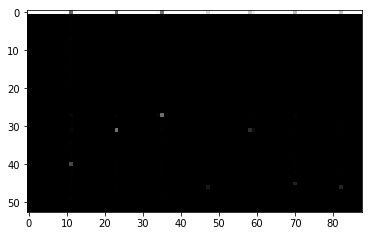

In [6]:
model.to("cuda:0")
trainer = helpers.LineTrainer(model)
imshow(trainer.probs_batch(images).numpy()[0].T)

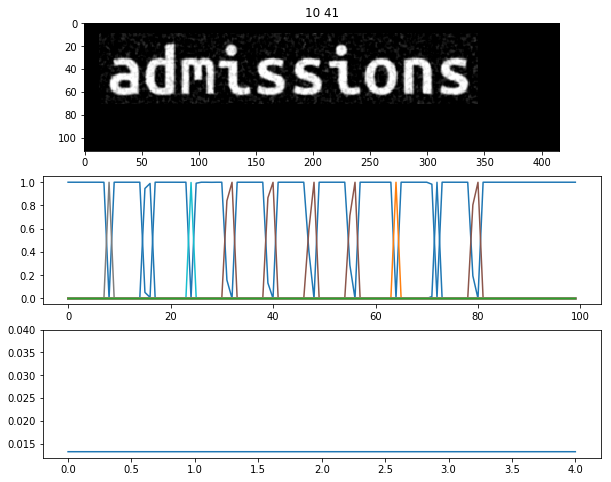

KeyboardInterrupt: 

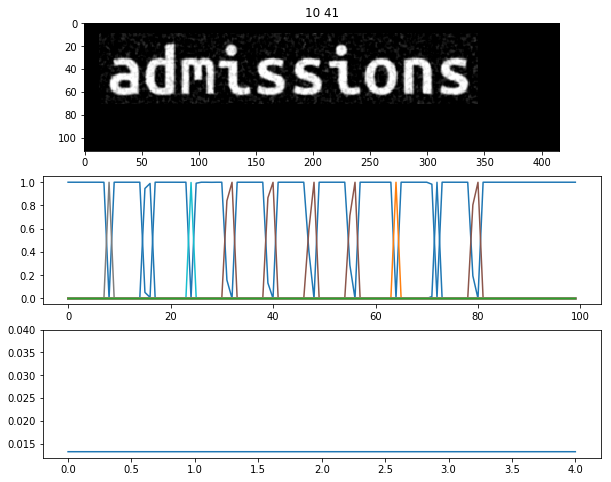

In [7]:
trainer.train(training_dl, 20, start_epoch=epoch)
IPython.display.clear_output(wait=True)

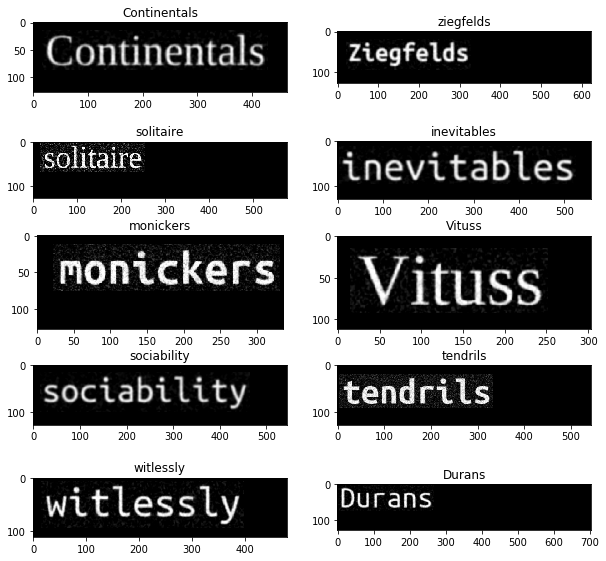

In [22]:
figsize(10, 10)
for i, batch in enumerate(islice(training_dl, 0, 10)):
    subplot(5, 2, i+1)
    result = trainer.predict_batch(*batch[:2], threshold=0.8)
    imshow(batch[0][0,:,:,0].detach().numpy())
    title(decode_str(result[0]))

In [23]:
trainer.errors(testing_dl)

(489, 81642)